In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np
#from jax import numpy as jnp

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 1000
SEED = 0

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            #labels.append([t, 1-t])
            #labels.append([np.sin(np.pi/4*t), np.cos(np.pi/4*t)])
            #labels.append([[1, 0],[t,1-t]])
            x=[t,1-t,0,0]
            xr=np.array(x).reshape([2,2])
            labels.append(xr)
            print(xr)
            #labels.append([[t, 0., 0],[1-t,0.,0]])
            #labels.append([[t, 0.],[1-t,0.]])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences

train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[0 1]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]
[[1 0]
 [0

In [5]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [6]:
from lambeq import Reader, cups_reader, spiders_reader, stairs_reader

raw_train_diagrams=[]
raw_dev_diagrams=[]
raw_test_diagrams=[]

#raw_train_diagrams = cups_reader.sentence2diagram(train_data)
#raw_dev_diagrams = cups_reader.sentence2diagram(dev_data)
#raw_test_diagrams = cups_reader.sentence2diagram(test_data)

for i in range(70):
    raw_train_diagrams.append(cups_reader.sentence2diagram(train_data[i]))
for i in range(30):
    raw_dev_diagrams.append(cups_reader.sentence2diagram(dev_data[i]))
for i in range(30):
    raw_test_diagrams.append(cups_reader.sentence2diagram(test_data[i]))

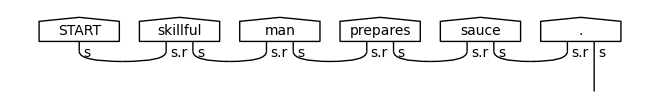

In [7]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = raw_train_diagrams
dev_diagrams = raw_dev_diagrams
test_diagrams = raw_test_diagrams

train_diagrams[0].draw()

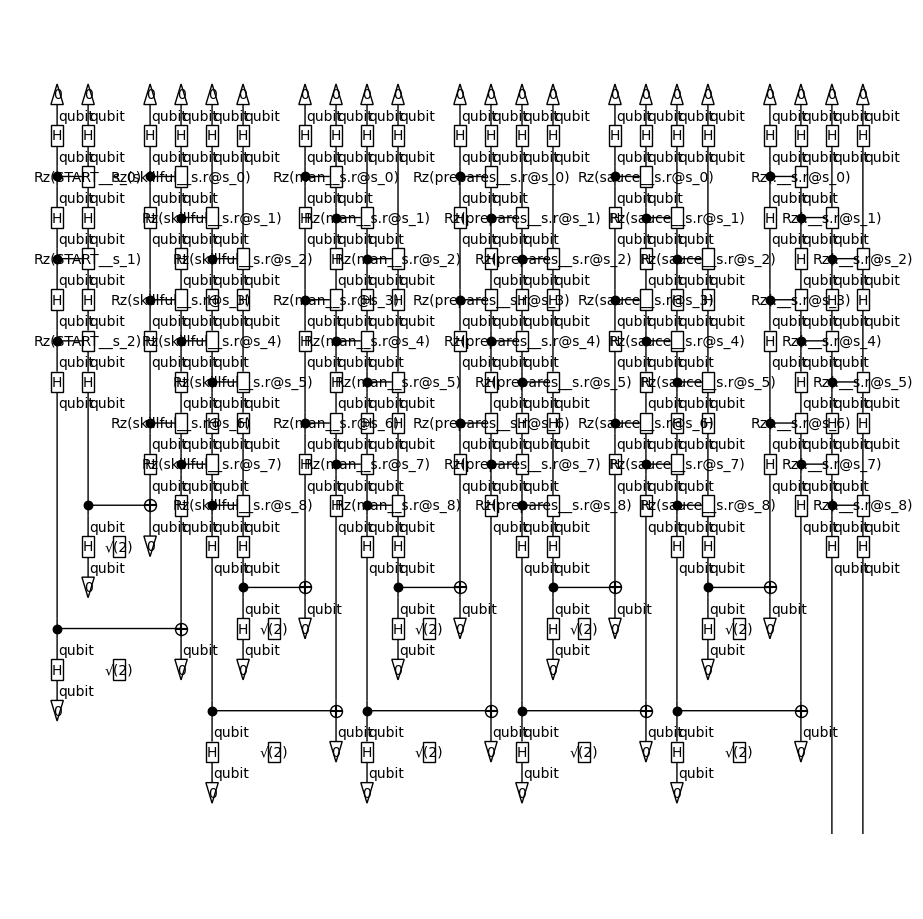

In [8]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 2},
                   n_layers=3, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 9))

In [9]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [10]:
from lambeq import CELoss, CELoss4

# Using the builtin binary cross-entropy error from lambeq
#bce = BinaryCrossEntropyLoss(use_jax=True)


In [11]:
ce = CELoss4(use_jax=True)

#acc = lambda y_hat, y: [For s in range(len(y))np.round(y_hat[ , 0,0]) == y[ ,0,0]) / len(y)  # half due to double-counting

In [12]:
def acc(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0]
            s1=y[s,0,1]
            s2=y[s,1,0]
            s3=y[s,1,1]
            ptrue.append(np.array([s0, s1, s2, s3]))
            
        qtrue=np.array(ptrue)
 
        ppredic= [ ]
        for s in range(len(y_hat)):
            p0=y_hat[s,0,0]
            p1=y_hat[s,0,1]
            p2=y_hat[s,1,0]
            p3=y_hat[s,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            qq=q0+q1+q2+q3
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n]))
        
        ppre=np.array(ppredic)
    
        Error=0.0
        
        for s  in range(len(y)):
            p=(ppre[s,0]-qtrue[s,0])**2+(ppre[s,1]-qtrue[s,1])**2+(ppre[s,2]-qtrue[s,2])**2+(ppre[s,3]-qtrue[s,3])**2
            #p=numpy.dot(ppre[s,:], ptrue[s,:])
            Error= Error+p
            Error=Error/len(y)
            AC=1.0-Error

        return AC

In [13]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

In [14]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [15]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

Epoch 50:    train/loss: 2.3889   valid/loss: 1.8182   train/acc: 0.9910   valid/acc: 0.9956
Epoch 100:   train/loss: 0.8202   valid/loss: 0.9416   train/acc: 0.9938   valid/acc: 0.9972
Epoch 150:   train/loss: 0.8229   valid/loss: 0.6675   train/acc: 0.9644   valid/acc: 0.9810
Epoch 200:   train/loss: 0.6696   valid/loss: 0.7681   train/acc: 0.9743   valid/acc: 0.9887
Epoch 250:   train/loss: 0.6657   valid/loss: 0.7004   train/acc: 0.9796   valid/acc: 0.9912
Epoch 300:   train/loss: 0.3805   valid/loss: 0.2715   train/acc: 0.9886   valid/acc: 0.9999
Epoch 350:   train/loss: 0.6597   valid/loss: 0.3338   train/acc: 0.9910   valid/acc: 0.9972
Epoch 400:   train/loss: 0.1079   valid/loss: 0.1249   train/acc: 1.0000   valid/acc: 0.9987
Epoch 450:   train/loss: 0.0727   valid/loss: 0.0995   train/acc: 0.9989   valid/acc: 0.9996
Epoch 500:   train/loss: 0.0822   valid/loss: 0.0626   train/acc: 0.9994   valid/acc: 0.9995
Epoch 550:   train/loss: 0.0453   valid/loss: 0.0431   train/acc: 0.99

Test accuracy: 0.9999951408434304


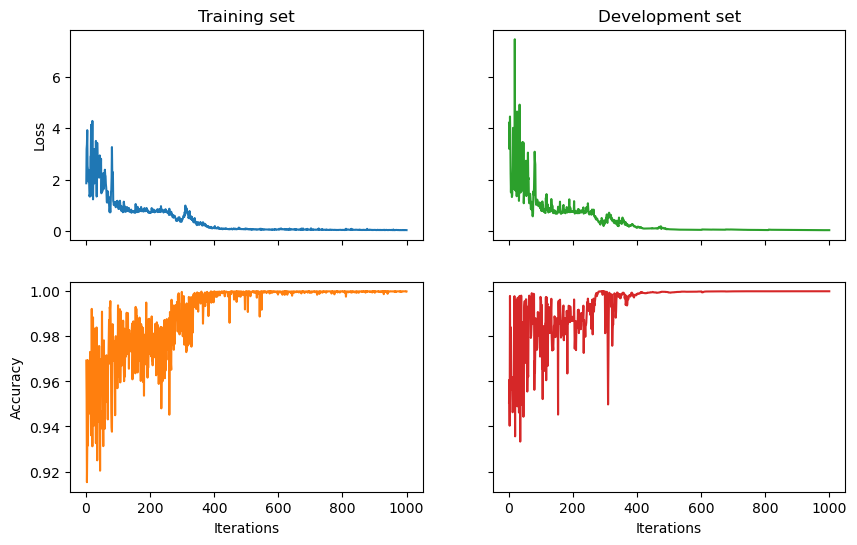

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)

In [ ]:
def OutAcc1(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0]
            s1=y[s,0,1]
            s2=y[s,1,0]
            s3=y[s,1,1]
            ptrue.append(np.array([s0, s1, s2, s3]))
            
        return ptrue

In [ ]:
def OutAcc2(y_hat, y):
    
    ppredic= [ ]
     
    for s in range(len(y_hat)):
            p0=y_hat[s,0,0]
            p1=y_hat[s,0,1]
            p2=y_hat[s,1,0]
            p3=y_hat[s,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            qq=q0+q1+q2+q3
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n]))
        
    ppre=np.array(ppredic)
        
    return ppre

In [19]:
test_out1 = OutAcc1(model(test_circuits), np.array(test_labels))

In [20]:
test_out2= OutAcc2(model(test_circuits), np.array(test_labels))

In [21]:
test_out1

[array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([1, 0, 0, 0])]

In [22]:
test_out2

array([[9.8122609e-01, 3.5392626e-03, 1.5234196e-02, 4.9614897e-07],
       [9.9201447e-01, 5.6271376e-03, 6.1838265e-04, 1.7400606e-03],
       [2.2274068e-02, 9.6724600e-01, 4.8466172e-04, 9.9952538e-03],
       [9.9977720e-01, 2.1590929e-05, 1.9164694e-05, 1.8201597e-04],
       [9.8975211e-01, 8.6985575e-04, 9.3402248e-03, 3.7749473e-05],
       [7.5487811e-03, 9.8325050e-01, 6.2956200e-03, 2.9050866e-03],
       [3.3042163e-03, 9.7732693e-01, 2.9890260e-04, 1.9069966e-02],
       [1.7347155e-02, 9.3223411e-01, 5.0416086e-02, 2.7071173e-06],
       [9.8951375e-01, 7.8635272e-03, 9.5677364e-04, 1.6659719e-03],
       [9.8269427e-01, 1.4252519e-02, 4.5544354e-04, 2.5977944e-03],
       [9.8585647e-01, 5.4952847e-03, 8.6424612e-03, 5.7362458e-06],
       [1.8732209e-02, 9.2944211e-01, 5.1824365e-02, 1.4047276e-06],
       [1.7342135e-02, 9.7107393e-01, 4.1052164e-04, 1.1173461e-02],
       [9.9157298e-01, 1.0802682e-03, 2.2305890e-03, 5.1161675e-03],
       [9.9319255e-01, 4.1956115e-